In [1]:
#import libraries

import os
import warnings
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import torch
import torch.nn as nn
import numpy as np  
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.')
else:
    print('CUDA is available.')

CUDA is not available.


In [2]:
#import torch

from torch.utils.data import DataLoader
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import pandas as pd

#data
from skimage import io, transform
%matplotlib inline

In [3]:
#load data

training_path='/Users/luyaowang/Desktop/dataset/' 
test_path='/Users/luyaowang/Desktop/testcnn/' 

batch_size=4
#Depends on memory size

num_workers=0
transform = transforms.Compose([transforms.Resize((256,256)),
                                transforms.Grayscale(num_output_channels=1),
                                    transforms.ToTensor()])

    
# import datasets using ImageFolder
training_dataset = datasets.ImageFolder(training_path, transform)
test1_dataset = datasets.ImageFolder(test_path, transform)



#Classification train validation
length=len(training_dataset)
training_size,validatation_size=int(0.8*length),int(0.2*length)
training_set,validatation_set=torch.utils.data.random_split(training_dataset,[training_size,validatation_size])




#split test part in the training data
# validatation_size, testing_size=int(0.1*length),int(0.1*length)
# validatation_set, testing_set=torch.utils.data.random_split(validatation_set,[validatation_size, testing_size])



# put into DataLoaders
training_loader = DataLoader(dataset=training_set, batch_size=batch_size, 
                          shuffle=True, num_workers=num_workers)
validation_loader = DataLoader(dataset=validatation_set, batch_size=batch_size, 
                          shuffle=True, num_workers=num_workers)



#test before
# testing_loader = DataLoader(dataset=testing_set, batch_size=batch_size, 
#                           shuffle=True, num_workers=num_workers)

test1_loader = DataLoader(dataset=test1_dataset, batch_size=batch_size, 
                          shuffle=True, num_workers=num_workers)






classes = ['glioma_tumor','meningioma_tumor', 'no_tumor', 'pituitary_tumor']


In [4]:
#model


class BrainTumorModel(nn.Module):
    def __init__(self):
        super(BrainTumorModel, self).__init__()
        self.c0 = nn.Conv2d(1, 32, kernel_size=(3, 3)) #1 channel to 32
        self.r = nn.ReLU()
        self.m0 = nn.MaxPool2d(2, 2)#Pick largest pixel
        self.c1 = nn.Conv2d(32, 64, kernel_size=(3, 3))
        self.m1 = nn.MaxPool2d(2, 2)
        self.c2 = nn.Conv2d(64, 128, kernel_size=(3, 3))
        self.m2 = nn.MaxPool2d(2, 2)
        self.c3 = nn.Conv2d(128, 128, kernel_size=(3, 3))#different weight get more feature
        self.m3 = nn.MaxPool2d(2, 2)
        self.f = nn.Flatten()
        self.dr = nn.Dropout(0.35)#remove 35%
        self.l0 = nn.Linear(25088, 512)
        self.l1 = nn.Linear(512, 4)

    
    def forward(self, X):
        X = self.c0(X)
        X = self.r(X)
        X = self.m0(X)
        X = self.c1(X)
        X = self.r(X)
        X = self.m1(X)
        X = self.c2(X)
        X = self.r(X)
        X = self.m2(X)
        X = self.c3(X)
        X = self.r(X)
        X = self.m3(X)
        X = self.f(X)
        X = self.dr(X)
        X = self.l0(X)
        X = self.l1(X)

        
        return X

In [5]:
model = BrainTumorModel()

if train_on_gpu:
    model.cuda()
criterion = nn.CrossEntropyLoss()
# call loss function

optimizer = torch.optim.Adam(model.parameters())
# call optimizer
model

BrainTumorModel(
  (c0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (r): ReLU()
  (m0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (c1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (m1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (c2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (m2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (c3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
  (m3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (f): Flatten(start_dim=1, end_dim=-1)
  (dr): Dropout(p=0.35, inplace=False)
  (l0): Linear(in_features=25088, out_features=512, bias=True)
  (l1): Linear(in_features=512, out_features=4, bias=True)
)

In [6]:
#traning

n_epochs = 20

valid_loss_min = np.Inf

#list value for plot
valid_loss_list = []
train_loss_list = []

for epoch in range(n_epochs):

    
    #Clear after each epoch
    train_loss = 0.0
    valid_loss = 0.0
    
 
    model.train()
    for data, target in training_loader:
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        optimizer.zero_grad() # clear optimizer
        output = model(data)#predicted outputs
        loss = criterion(output, target)# calculate batch loss
        loss.backward()
        optimizer.step()#optimization
        train_loss += loss.item()*data.size(0)# update training loss
        
  

    #validate
    model.eval()
    for data, target in validation_loader:
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()  
        output = model(data)
        loss = criterion(output, target)
        valid_loss += loss.item()*data.size(0) # update validation loss 
    
    train_loss = train_loss/len(training_loader.sampler)# calculate average losses
    valid_loss = valid_loss/len(validation_loader.sampler)
    
    
    # using for draw the figure
    valid_loss_list.append(valid_loss)
    train_loss_list.append(train_loss)
    
    
    
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    
    
    if valid_loss <= valid_loss_min:
        print('Validation loss decreasd from {:.6f} to {:.6f}. Model is saving.'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'brain_test.pt')# save model if validation loss smaller then before
        valid_loss_min = valid_loss
    else:
        print('Model does not need to be saved.')
        
        

Epoch: 1 	Training Loss: 0.797055 	Validation Loss: 0.760554
Validation loss decreasd from 0.766865 to 0.760554. Model is saving.
Epoch: 2 	Training Loss: 0.656181 	Validation Loss: 0.654514
Validation loss decreasd from 0.760554 to 0.654514. Model is saving.
Epoch: 3 	Training Loss: 0.569682 	Validation Loss: 0.560518
Validation loss decreasd from 0.654514 to 0.560518. Model is saving.
Epoch: 4 	Training Loss: 0.499683 	Validation Loss: 0.491915
Validation loss decreasd from 0.560518 to 0.491915. Model is saving.
Epoch: 5 	Training Loss: 0.431359 	Validation Loss: 0.473668
Validation loss decreasd from 0.491915 to 0.473668. Model is saving.
Epoch: 6 	Training Loss: 0.369067 	Validation Loss: 0.439337
Validation loss decreasd from 0.473668 to 0.439337. Model is saving.
Epoch: 7 	Training Loss: 0.328116 	Validation Loss: 0.425385
Validation loss decreasd from 0.439337 to 0.425385. Model is saving.
Epoch: 8 	Training Loss: 0.272571 	Validation Loss: 0.390555
Validation loss decreasd from

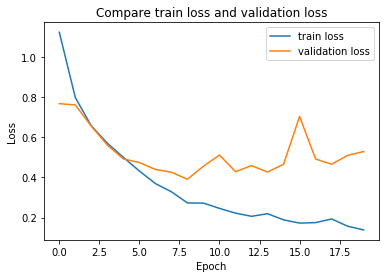

In [8]:
import matplotlib.pyplot as plt
x_lab = list(range(20))

# x_lab = list(range(n_epochs))
plt.title('Compare train loss and validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
l1,=plt.plot(x_lab, train_loss_list)
l2,=plt.plot(x_lab, valid_loss_list)
plt.legend(handles=[l1,l2],labels=['train loss','validation loss'])
# plt.plot(x_lab, train_loss_list)
# plt.plot(x_lab, valid_loss_list)
plt.show()


In [9]:
# test loss
# clear test loss
test_loss = 0.0

class_correct = [0 for _ in range(4)]
class_total = [0 for _ in range(4)]

model.eval()
counter=0


for data, target in test1_loader:
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    output = model(data)
    loss = criterion(output, target)
       

    test_loss += loss.item()*data.size(0)
    _, pred = torch.max(output, 1) # change to predict class
    correct_tensor = pred.eq(target.data.view_as(pred))  # compare label
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())

    
#accuracy

    for i in range(batch_size):
        
        label = target[i].data
        class_correct[label] += correct[i].item()
        class_total[label] += 1
        counter += 1
       

#average test loss
test_loss = test_loss/len(test1_loader.dataset)
print('Test loss is {:.3f}'.format(test_loss))

for i in range(4):
    print('Accuracy for %5s is: %.3f%% (%2d/%2d)' % (
        classes[i], 100 * class_correct[i] / class_total[i],
        np.sum(class_correct[i]), np.sum(class_total[i])))

        
print('Accuracy for the test data is  %.3f%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))



Test loss is 0.628
Accuracy for glioma_tumor is: 76.744% (33/43)
Accuracy for meningioma_tumor is: 91.176% (62/68)
Accuracy for no_tumor is: 81.081% (30/37)
Accuracy for pituitary_tumor is: 100.000% (52/52)
Accuracy for the test data is  88.500% (177/200)
